In [1]:
casename = "Validate center of mass - 3-body swim";

### Include Dyn3d and config files

In [2]:
using Pkg
Pkg.activate("../..")

using Revise
using Dyn3d
using Interact, Reactive
using Plots
pyplot()

┌ Info: Recompiling stale cache file /home/fs/.julia/compiled/v1.1/Dyn3d/wjQXj.ji for Dyn3d [d8047ffa-7f43-11e9-2204-adfbb6974ec5]
└ @ Base loading.jl:1184


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-7250137671489496761\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-14800616137705701581\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio/main\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n        console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n        require([\"/assetserver/683a7301d38db30e6ed147bab5e3d38a784973f9-dist/main.js\"], function (webIOModule) {\n            webIOModule.load_ipython_extension();\n        });\n        warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<div\n    id=\"webio-warning-7250137671489496761\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    <!-- TODO: link to installation docs. -->\n</div>\n")

Plots.PyPlotBackend()

In [3]:
# problem dimension
ndim = 2
# numerical params
tf = 20
dt = 5e-3
scheme = "Liska"
st = 5
tol = 1e-4
num_params = NumParams(tf, dt, scheme, st, tol)
# gravity
gravity = [0., 0., 0.]

# set up system config info
config_system = ConfigSystem(ndim, gravity, num_params)

# set up bodys
nbody = 3
config_body = ConfigBody(nbody, 4, [0. 0.; 1. 0.; 1. 1.0; 0. 1.0], 1.0)
config_bodys = fill(config_body, nbody)

# set up joints
njoint = nbody
config_joints = Vector{ConfigJoint}(undef,njoint)
gap = 0.0;

In [4]:
stiff = 0.05

0.05

In [5]:
dof₁ = Vector{Dof}(undef,3)
[dof₁[i] = Dof(i+2, "passive", 0., 0., Motions()) for i = 1:3]
config_joints[1] = ConfigJoint(njoint, "planar",
    [0.,0.,0.,0.6,2.0,0.], zeros(Float64,6), 0, dof₁, [0.0,0.0,0.0]);

In [6]:
motion₂ = Motions("oscillatory", [-1.0, 1.0/(2*π), -π/2])
dof₂ = Dof(3, "active", stiff, 0., motion₂)
config_joints[2] = ConfigJoint(njoint, "revolute",
   [0., 0., 0., 1.0+gap, 0., 0.],[0., 0., 0., -gap, 0., 0.],
   1, [dof₂], [0.]);

In [7]:
motion₃ = Motions("oscillatory", [-1.0, 1.0/(2*π), 0.0])
dof₃ = Dof(3, "active", stiff, 0., motion₃)
config_joints[3] = ConfigJoint(njoint, "revolute",
   [0., 0., 0., 1.0+gap, 0., 0.],[0., 0., 0., -gap, 0., 0.],
   2, [dof₃], [0.]);

### Build joint-body chain

In [8]:
bodys, joints, system = BuildChain(config_bodys, config_joints,
                                   config_system)
bd = BodyDyn(bodys, joints, system)

This is a 3 body-joint system, system is un-mounted from space

### Initialize system state

In [9]:
# init system
bd, soln = InitSystem!(bd)

# init soln structure
solns = (Soln)[]
push!(solns, soln)

# init VertsHistory struct
vs = []
push!(vs, VertsHistory(system.nbody, bd.bs));

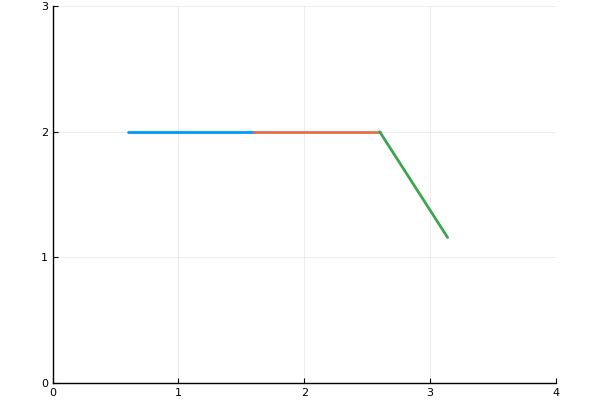

In [10]:
@getfield bd (bs, js, sys)
bs, js, sys = UpdatePosition!(bs, js, sys, soln.qJ)
vs₀ = VertsHistory(sys.nbody, bs);

p = plot()
for i = 1:sys.nbody
    plot!(p,vs₀[i,2:3,1], vs₀[i,2:3,2],linewidth=2)
end
plot!(xlims=(0,4), ylims=(0,3), ratio=1, legend=false)

### Set up HERKBody object

In [11]:
herk = HERKBody(system.num_params,HERKFuncM, HERKFuncGT, HERKFuncG,
                (HERKFuncf,HERKFuncgti), (UpdatePosition!,UpdateVelocity!),
                _conservationcheck=true)

Order-3 HERK time-marching function like object for Dyn3d


### Time Marching

#### Note that sometimes the solver can break due to singular matrix. Change between fixed step or not to solve the problem

In [12]:
λhist = []
bdhist = []
thist = [];

In [13]:
idx = 0
@time begin
while soln.t < tf
    # advance one step
    global soln, bd, dict = herk(soln, bd, _isfixedstep=true)

    # record soln and verts_i info
    push!(solns, soln)
    push!(vs, VertsHistory(system.nbody, bd.bs))
    push!(thist,deepcopy(soln.t)) 
    push!(λhist,deepcopy(soln.λ))
    push!(bdhist,deepcopy(bd))
        
    # print progress
    global idx += 1
    if mod(idx,500) == 1
        println("itr = $(idx), t = $(round(soln.t,digits=2)), dt = $(round(soln.dt,digits=4))")
    end
end
println("itr = $(idx), t = $(round(soln.t,digits=2)), dt = $(round(soln.dt,digits=4)) \n")
end

itr = 1, t = 0.0, dt = 0.005
itr = 501, t = 2.5, dt = 0.005
itr = 1001, t = 5.0, dt = 0.005
itr = 1501, t = 7.5, dt = 0.005
itr = 2001, t = 10.01, dt = 0.005
itr = 2501, t = 12.51, dt = 0.005
itr = 3001, t = 15.01, dt = 0.005
itr = 3501, t = 17.51, dt = 0.005
itr = 4000, t = 20.0, dt = 0.005 

 21.023653 seconds (26.36 M allocations: 2.421 GiB, 9.41% gc time)


### Gif time

In [14]:
# Total number of seconds of this gif
gif_time = 8;

In [15]:
vs = []
for i = 1:length(thist)
    push!(vs, VertsHistory(nbody, bdhist[i].bs))
end

xs = []
ys = []
xc = []
yc = []

for k = 1:length(thist)
    xstmp = []
    ystmp = []
    for i = 1:nbody
        for j = 2:3
            # verts coord
            push!(xstmp,vs[k][i,j,1])
            push!(ystmp,vs[k][i,j,2])          
        end
    end
    push!(xs,xstmp)
    push!(ys,ystmp)
    
    # center of mass
    @getfield bdhist[k] (bs,sys)
    center = MassCenter(bs,sys)
    push!(xc,center[1])
    push!(yc,center[2])  
    
end

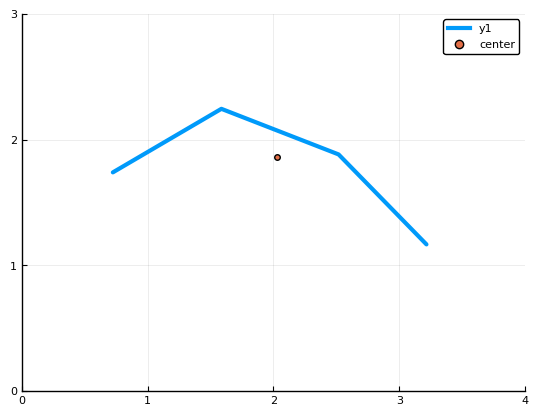

┌ Info: Saved animation to 
│   fn = /mnt/g/Research/Dyn3d.jl/test/notebook_verify_mass_center/Validate center of mass - 3-body swim.gif
└ @ Plots /home/fs/.julia/packages/Plots/oiirH/src/animation.jl:90


Plots.AnimatedGif("/mnt/g/Research/Dyn3d.jl/test/notebook_verify_mass_center/Validate center of mass - 3-body swim.gif")

In [16]:
freq = round(Int,idx/30/gif_time)


v2_x = []
v2_y = []

anim = @animate for i = 1:freq:length(thist)
    p = plot(xs[i],ys[i], linewidth=3)   
    scatter!(p,[xc[i]],[yc[i]],markersize=4, label="center")
    plot!(xlims=(0,4), ylims=(0,3), aspect_ratio=:equal)        
end        

gif(anim, casename*".gif", fps = 30)